In [4]:
import tensorflow as tf
import tensorflow_probability as tfp

from src.ksd.ksd import KSD, PKSD
from src.ksd.kernel import IMQ
import src.ksd.langevin as mcmc


In [5]:
tf.random.set_seed(2022)

# Set-ups: Bi-modal mixture of Gaussian
We consider the first example in the experiments section of the paper. The target density is
$$
    p(x) \propto \pi_p \exp\left( - 0.5 * \| x \|_2^2 \right) + (1 - \pi_p) \exp\left( -0.5 * \| x - e_1\|_2^2 \right),
$$
where $\pi_p = 0.5$, and $e_1 = (1, 0, \ldots, 0)^\intercal \in \mathbb{R}^d$.

In [6]:
dim = 2
pi_p = 0.5

In [7]:
mean1 = tf.zeros(dim)
mean2 = tf.eye(dim)[0, :] * 6.

def log_prob(x):
    """Log prob density of the target up to an additive constant"""
    log_ratio1 = tf.math.log(pi_p)
    log_ratio2 = tf.math.log(1-pi_p)
    
    exp1 = tf.reduce_sum((x - mean1)**2, axis=-1) # n
    exp2 = tf.reduce_sum((x - mean2)**2, axis=-1) # n
    exps = tf.stack([-0.5 * exp1 + log_ratio1, -0.5 * exp2 + log_ratio2]) # 2 x n
    return tf.math.reduce_logsumexp(exps, axis=0) # n

Samples are drawn from the *left component*, i.e. the same density but with $\pi_p$ replaced by $\pi_q = 1$.

In [8]:
def sample_from_target(n, ratio):
    """Sample from the candidate distribution"""
    mix1 = tf.random.normal((n, dim)) + mean1
    mix2 = tf.random.normal((n, dim)) + mean2
    unif = tf.random.uniform((n, 1))
    x = tf.where(unif <= ratio, mix1, mix2)
    return x

In [9]:
# draw sample
n = 1000
samples = sample_from_target(n, ratio=1.)

# KSD test
The goal is to test $H_0: Q = P$ against $H_1: Q \neq P$.

To perform KSD test, we need to instantiate
1. a positive definite kernel: we use IMQ kernels with the median heuristic (see paper for details)
2. a KSD object, which takes in a p.d. kernel and the log prob of the target

In [10]:
kernel = IMQ(med_heuristic=True)
ksd = KSD(kernel=kernel, log_prob=log_prob)

In [11]:
# compute test statistic and p-value using 1000 bootstrap samples 
ksd_hat, ksd_pval = ksd.test(x=samples, num_boot=1000)

print("KSD test: \ntest statistic: {:.3g}, p-value: {:.3g}".format(ksd_hat, ksd_pval))

KSD test: 
test statistic: -0.00159, p-value: 0.901


The large $p$-value suggests no evidence of rejection, even though the sample has completely missed the other mode. 

This is because the score functions of the target distribution $P$ and the candidate distribution $Q$ are very similar on regions where we have sample.

(Even though the population KSD is always non-negative, the test statistic can be negative because a U-statistic does not ensure positivity.)

# pKSD test
To perform pKSD test, we need to provide a few more things (see paper for details):
1. a perturbation kernel: in this case a MH transition kernel leaving $p$ invariant,
2. number of steps to apply the perturbation kernel.
3. a list of candidate jump scales for the transition kernel,
4. a training set for finding the optimal jump scale, and a test set for computing the p-value
5. starting points for the optimiser

In [12]:
# MH transition kernel
mh_kernel = mcmc.RandomWalkMH

# number of steps to apply transition kernel
T = 10

# candidate jump scales
jump_ls = tf.linspace(0.5, 1.5, 21)

# train/test split
ntrain = n//2
sample_train, sample_test = samples[:ntrain, ], samples[ntrain:, ]

# starting points to initialise optimiser for finding
# modes and Hessians
init_points = tf.concat([
    sample_train[:(ntrain//2)], 
    tf.random.uniform((ntrain//2, dim), minval=-10, maxval=10) 
], axis=0) # ntrain x dim

In [13]:
# instantiate PKSD class
pksd = PKSD(kernel=kernel, pert_kernel=mh_kernel, log_prob=log_prob)

In [14]:
# find modes and Hessians
pksd.find_modes(init_points, threshold=1., max_iteration=500)

In [15]:
# compute test statistic and p-value using 1000 bootstrap samples 
pksd_hat, pksd_pval = pksd.test(
    xtrain=sample_train, 
    xtest=sample_test, 
    T=T, 
    jump_ls=jump_ls, 
    num_boot=1000, 
  )

print("pKSD test: \ntest statistic: {:.3g}, p-value: {:.3g}".format(pksd_hat, pksd_pval))

pKSD test: 
test statistic: 0.106, p-value: 0.001


Unlike KSD, the small $p$-value of the pKSD test suggests a clear rejection at a level $\alpha = 0.05$, demonstrating the capability of pKSD in detecting differences in mixing proportions.

A similar observation could be drawn if the sample was drawn from *both* components but with a different mixing proportion, i.e., setting $\pi_q \in (0, 1)$ with $\pi_q \neq \pi_p$.

# Visualise samples before and after perturbations

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

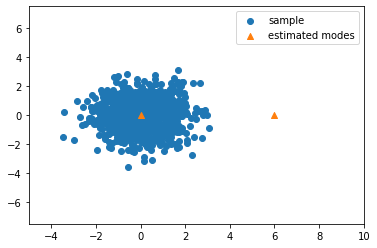

In [17]:
# visualise samples and estimated mode locations
modes_list = pksd.proposal_dict["modes"]
modes = tf.concat(modes_list, axis=0)

_ = plt.scatter(samples[:, 0], samples[:, 1], label="sample")
_ = plt.scatter(modes[:, 0], modes[:, 1], marker="^", label="estimated modes")
_ = plt.legend()
_ = plt.xlim(-5., 10.)
_ = plt.ylim(-7.5, 7.5)

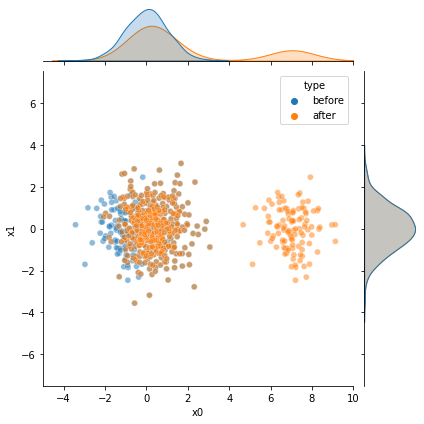

In [18]:
# plot test data before and after perturbation
samples_df = pd.DataFrame({
    "x0": tf.concat([pksd.x[0, :, 0], pksd.x[-1, :, 0]], axis=0),
    "x1": tf.concat([pksd.x[0, :, 1], pksd.x[-1, :, 1]], axis=0),
    "type": ["before"]*(n-ntrain) + ["after"]*(n-ntrain)
})

_ = sns.jointplot(
    data=samples_df,
    x="x0",
    y="x1",
    hue="type",
    xlim=[-5., 10.],
    ylim=[-7.5, 7.5],
    alpha=0.5
)